In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import cvxpy as cp
from numpy import array, eye, hstack, ones, vstack, zeros
import copy
import pandas as pd

In [3]:
class soccer_game():
    
    def __init__(self, playerA, playerB):
        self.player1 = playerA
        self.player2 = playerB
        
        self.rows = 2
        self.columns = 4
        
        self.player1_goal = [0,4]
        self.player2_goal = [3,7]
        
        self.ball = np.random.randint(2) #0 or 1 at random
        
        self.ball_possession = playerA.pos
        
       
    def make(self, randomize = True):
        available_cells = [1,2,5,6]
        
        random_cell = np.random.choice(len(available_cells), 2, replace=False)
        
        if randomize:
            
            playerA.pos = available_cells[random_cell[0]]
            playerB.pos = available_cells[random_cell[1]]
            
            if np.random.randint(2)==0:
                self.ball = playerA.ball
                self.ball_possession = playerA.pos
            else:
                self.ball = playerB.ball
                self.ball_possession = playerB.pos
                
        else:
            
            playerA.pos = 2
            playerB.pos = 1
            self.ball = playerB.ball
            self.ball_possession = playerB.pos
            
    def move(self, player, action):
        
        if action == 0 and player.pos>3:
            new_loc = player.pos - 4
            
        elif action ==1 and player.pos not in self.player2_goal:
            new_loc = player.pos + 1
            
        elif action == 2 and player.pos<4:
            new_loc = player.pos + 4
            
        elif action == 3 and player.pos not in self.player1_goal:
            new_loc = player.pos - 1
            
        else:
            new_loc = player.pos
            
        return new_loc
        
    def actions(self, player1, player2, action1, action2):
        new_loc1 = self.move(player1, action1)
        new_loc2 = self.move(player2, action2)
        
        if new_loc1 != player2.pos: #Always player1 moves first
            player1.pos = new_loc1 #moving to the available cell
        else:
            self.ball = player2.ball #Ball moves to opponent if the cell is occupied
            
        if new_loc2 != player1.pos:
            player2.pos = new_loc2
        else:
            self.ball = player1.ball
            
        if self.ball:                              
            self.ball_possession = player1.pos
        else:
            self.ball_possession = player2.pos
            
    def step(self, action1, action2):
        
        p1 = self.player1
        p2 = self.player2
        
        if np.random.randint(2)==0:
            self.actions(p1, p2, action1, action2)
        else:
            self.actions(p2, p1, action2, action1)
            
        if self.ball_possession in self.player1_goal:
            reward_1 = 100
            reward_2 = -100
            end = 1
            #print("Goal by PlayerA!")
        
        elif self.ball_possession in self.player2_goal:
            reward_1 = -100
            reward_2 = 100
            end = 1
            #print("Goal by PlayerB!")
            
        else:
            reward_1 = 0
            reward_2 = 0
            end = 0
            
        return self.state(), reward_1, reward_2, end
    
    def state(self):
        return [playerA.pos, playerB.pos, env.ball]


class player():

    def __init__(self, name="", ball = None):
        self.name = name
        self.score = 0
        self.pos = 0
        self.ball = ball
        print("Player {} Created".format(name))

    def has_ball(self):
        return self.ball

def graph_error(error_list, iter_list, name="", linewidth = 1):

    plt.plot(iter_list, error_list, linewidth = linewidth)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    plt.title(name)
    plt.xlabel('Iteration')
    plt.ylim(0, 0.5)
    plt.ylabel('Q Value Difference')
    plt.show()
    plt.gcf().clear()

In [4]:
def solve_LP(mat):

  A = copy.copy(mat.T)
  #A = copy.copy(mat)
        
  I = np.zeros((5, 5))

  for ww in range(5):
    I[ww, ww] = 1
        
  A = np.vstack((A, I))
  A = np.hstack(
            (A, [[-1], [-1], [-1], [-1], [-1], [0], [0], [0], [0], [0]]))
    
  A = np.vstack(
            (A, [1, 1, 1, 1, 1, 0], [-1, -1, -1, -1, -1, 0]))
    
  b = np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., -1.])
    
    
  c = np.array([0., 0., 0., 0., 0., 1.])
        
  #print("Hit 2")
    
  x = cp.Variable(5+1)
    
  prob = cp.Problem(cp.Minimize(-c.T@ x),[-A @ x <= -b])
    
  v_value = prob.solve()

  #print (v_value)
        
    
  x_value = x.value

  return x_value, v_value


In [5]:
def solve_LP_new(mat):
    A = np.matrix(mat)
  #A = copy.copy(mat)
        
    I = np.zeros((5, 5))

    for ww in range(5):
        I[ww, ww] = 1
        
    A = np.vstack((-A, -I))
    A = np.hstack(
            ([[1], [1], [1], [1], [1], [0], [0], [0], [0], [0]],A))
    
    A = np.vstack(
            (A, [0, 1, 1, 1, 1, 1]))
    
    b = np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
    
    
    c = np.array([-1., 0., 0., 0., 0., 0.])
        
  #print("Hit 2")
    
    x = cp.Variable(5+1)
    
    prob = cp.Problem(cp.Minimize(c.T@ x),[A @ x <= b])
    
    v_value = prob.solve()

  #print (v_value)
        
    
    x_value = x.value

    return x_value, -v_value

In [6]:
def Foe_Q(env, playerA, playerB, start_randomize = True, greenwald_off_policy = True):
    
    #Greenwalds Off policy definition is different than Sutton's
    
    itt = 1000000 #from figure 3
    #itt = 10000
    t_start = time.time()
    
    ep = 1.0
    ep_min = 0.001
    ep_decay = 0.999995
    
    alpha = 1.0
    alpha_min = 0.001
    alpha_decay = 0.999995
    
    gamma = 0.9
    
    Qa = np.ones([8, 8, 2, 5, 5])
    Va = np.ones([8,8,2])

    pi_a = np.ones([8,8,2,5])/5

    Qb = np.ones([8, 8, 2, 5, 5])
    Vb = np.ones([8,8,2])

    pi_b = np.ones([8,8,2,5])/5

    
    env.make(start_randomize)
    end = 0
    
    error = []
    seq = []
    won = 0
    lost = 0
    wr = 0
    result = []
    
    numActions = 5
    
    for i in range(itt):
        
        if end == 1:
            env.make(start_randomize)
            
        pA = playerA.pos
        pB = playerB.pos
        ball = env.ball
        
        old_q_val = Qa[2,1,1,2,4]
 
        if ep > np.random.random():
            
            actA = np.random.choice(5) #5 actions
            actB = np.random.choice(5)
            
        else:
            #print(pi_a[pA,pB,ball])
            #print(sum(pi_a[pA,pB,ball]))
            actA = np.random.choice(np.arange(5),1,p=pi_a[pA,pB,ball]) #randomly choose an action according to policy pi_a
            actB = np.random.choice(5)
            
        next_state, rewardA, rewardB, end = env.step(action1 = actA, action2 = actB)
        na, nb, nball = next_state
        
        #next_Q = Qa[na, nb, nball]
        #print("Hit 1")

        current_Q_a = Qa[playerA.pos, playerB.pos, env.ball]
        
        xa_temp,va_temp = solve_LP_new(current_Q_a)
        #print(xa_temp)

        xa_temp = xa_temp[1:]
        #xa_temp[np.where(xa_temp<0)] = 0
        xa_temp = np.abs(xa_temp) / sum(np.abs(xa_temp))
        #print(xa_temp)
        
        Va[playerA.pos, playerB.pos, env.ball] = va_temp

        pi_a[playerA.pos, playerB.pos, env.ball] = xa_temp
        
        if end == 1:
            Qa[pA,pB,ball,actA, actB] = (1-alpha) *Qa[pA,pB,ball,actA, actB] + alpha*(1-gamma)*rewardA

            if rewardA == 100:
              won += 1
            else:
              lost += 1

        else:
            #print("Hit 4")
            Qa[pA,pB,ball,actA, actB] = (1-alpha) *Qa[pA,pB,ball,actA, actB] + alpha*((1-gamma)*rewardA + gamma *Va[na, nb, nball])


        if [pA, pB, ball, actA, actB] == [2, 1, 1, 2, 4]:
            err = abs(Qa[2,1,1,2,4] - old_q_val)

            if lost == 0  and won == 0:
              wr = 0

            else:
              wr = won/(won+lost)*100

            result.append([i,err,wr])
            print('\rstep {}\t Time: {:.2f} \t Percentage: {:.2f}% \t Alpha: {:.3f} \t Epsilon: {:.3f} \t Err: {:.3f} \t Win_Rate: {:.3f}'.format(i, time.time() - t_start, i*100/itt, alpha, ep,err,wr), end="")
 
        if greenwald_off_policy == False:
            ep *= np.e ** (-np.log(200.0) / 10 ** 6)
            ep = max(ep_min, ep)
        
        alpha *= np.e ** (-np.log(200.0) / 10 ** 6)
        alpha = max(alpha_min, alpha)
  

    return result

In [7]:
playerA = player(name="A", ball = 0)
playerB = player(name="B", ball = 1)

Player A Created
Player B Created


In [8]:
env = soccer_game(playerA, playerB)

step 999989	 Time: 4089.02 	 Percentage: 100.00% 	 Alpha: 0.005 	 Epsilon: 1.000 	 Err: 0.000 	 Win_Rate: 49.113

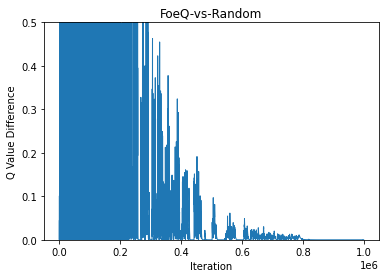

<Figure size 432x288 with 0 Axes>

In [9]:
Result = Foe_Q(env, playerA, playerB, start_randomize = False, greenwald_off_policy = True)

file_name = "/content/drive/MyDrive/Colab Notebooks/CEQ/FoeQ-vs-Random-shuffleStart-offPolicy"

df = pd.DataFrame(Result, columns = ["Itteration","Error", "WinRate"])
df.to_csv(file_name, index=False)

graph_error(df["Error"], df["Itteration"], name="FoeQ-vs-Random", linewidth = 1)

(0.0, 100.0)

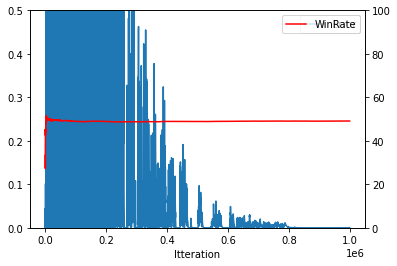

In [10]:
ax = df.plot("Itteration","Error")
plt.ylim(0, 0.5)
ax1 = ax.twinx()
df.plot("Itteration","WinRate",ax=ax1, color='r')
plt.ylim(0, 100)

step 998651	 Time: 3956.11 	 Percentage: 99.87% 	 Alpha: 0.005 	 Epsilon: 0.005 	 Err: 0.000 	 Win_Rate: 80.254

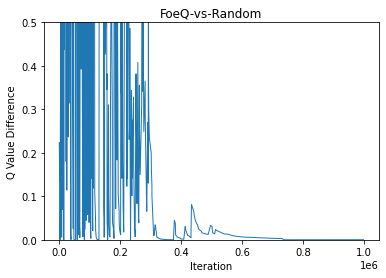

<Figure size 432x288 with 0 Axes>

In [11]:
Result = Foe_Q(env, playerA, playerB, start_randomize = True, greenwald_off_policy = False)
file_name = "/content/drive/MyDrive/Colab Notebooks/CEQ/FoeQ-vs-Random-shuffleStart-onPolicy"

df = pd.DataFrame(Result, columns = ["Itteration","Error", "WinRate"])
df.to_csv(file_name, index=False)

graph_error(df["Error"], df["Itteration"], name="FoeQ-vs-Random", linewidth = 1)

(0.0, 100.0)

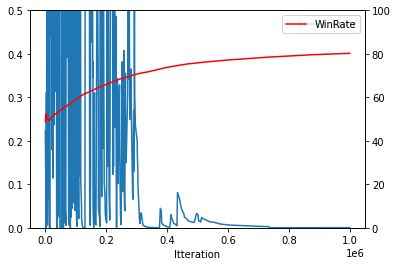

In [12]:
ax = df.plot("Itteration","Error")
plt.ylim(0, 0.5)
ax1 = ax.twinx()
df.plot("Itteration","WinRate",ax=ax1, color='r')
plt.ylim(0, 100)

step 999944	 Time: 3942.96 	 Percentage: 99.99% 	 Alpha: 0.005 	 Epsilon: 1.000 	 Err: 0.001 	 Win_Rate: 49.008

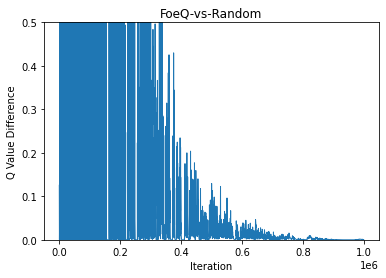

<Figure size 432x288 with 0 Axes>

In [14]:
Result = Foe_Q(env, playerA, playerB, start_randomize = False, greenwald_off_policy = True)
file_name = "/content/drive/MyDrive/Colab Notebooks/CEQ/FoeQ-vs-Random-strictStart-offPolicy"

df = pd.DataFrame(Result, columns = ["Itteration","Error", "WinRate"])
df.to_csv(file_name, index=False)

graph_error(df["Error"], df["Itteration"], name="FoeQ-vs-Random", linewidth = 1)

(0.0, 100.0)

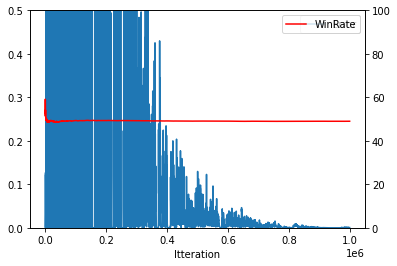

In [15]:
ax = df.plot("Itteration","Error")
plt.ylim(0, 0.5)
ax1 = ax.twinx()
df.plot("Itteration","WinRate",ax=ax1, color='r')
plt.ylim(0, 100)

step 993704	 Time: 3834.76 	 Percentage: 99.37% 	 Alpha: 0.005 	 Epsilon: 0.005 	 Err: 0.001 	 Win_Rate: 87.092

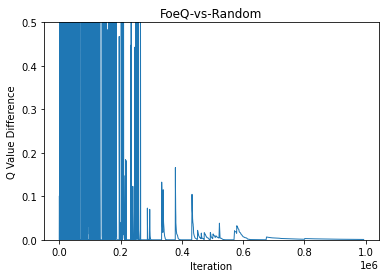

<Figure size 432x288 with 0 Axes>

In [16]:
Result = Foe_Q(env, playerA, playerB, start_randomize = False, greenwald_off_policy = False)
file_name = "/content/drive/MyDrive/Colab Notebooks/CEQ/FoeQ-vs-Random-strictStart-onPolicy"

df = pd.DataFrame(Result, columns = ["Itteration","Error", "WinRate"])
df.to_csv(file_name, index=False)

graph_error(df["Error"], df["Itteration"], name="FoeQ-vs-Random", linewidth = 1)

(0.0, 100.0)

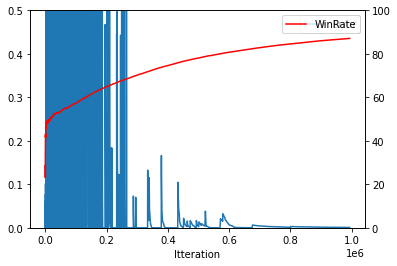

In [17]:
ax = df.plot("Itteration","Error")
plt.ylim(0, 0.5)
ax1 = ax.twinx()
df.plot("Itteration","WinRate",ax=ax1, color='r')
plt.ylim(0, 100)